In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
from sklearn.linear_model import LogisticRegression


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Finance_Trends.csv')
len(df)
df.head()

,gender,age,Investment_Avenues,Mutual_Funds,Equity_Market,Debentures,Government_Bonds,Fixed_Deposits,PPF,Gold,...,Duration,Invest_Monitor,Expect,What are your savings objectives?,Reason_Equity,Reason_Mutual,Reason_Bonds,Reason_FD,Avenue,Source
0,Male,29,Yes,2,4,7,5,3,1,6,...,Less than 1 year,Weekly,20%-30%,Health Care,Dividend,Fund Diversification,Assured Returns,Fixed Returns,Public Provident Fund,Newspapers and Magazines
1,Male,28,Yes,2,3,6,5,1,4,7,...,Less than 1 year,Weekly,30%-40%,Retirement Plan,Capital Appreciation,Better Returns,Assured Returns,Risk Free,Public Provident Fund,Television
2,Female,28,Yes,2,3,7,5,4,1,6,...,3-5 years,Daily,10%-20%,Health Care,Dividend,Better Returns,Assured Returns,Risk Free,Mutual Fund,Financial Consultants
3,Male,19,Yes,2,3,7,4,6,1,5,...,More than 5 years,Monthly,10%-20%,Retirement Plan,Capital Appreciation,Better Returns,Assured Returns,Risk Free,Equity,Newspapers and Magazines
4,Male,32,Yes,2,4,7,5,3,1,6,...,More than 5 years,Weekly,10%-20%,Retirement Plan,Capital Appreciation,Better Returns,Assured Returns,Fixed Returns,Public Provident Fund,Financial Consultants


In [ ]:
for col in df.columns:
    if df[col].isnull().any():
        print(f"Filling missing values in {col}")
        df[col].fillna(0, inplace=True)

In [ ]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

print(f"\nDataset splits:")
print(f"Training: {df_train.shape}")
print(f"Validation: {df_val.shape}")
print(f"Test: {df_test.shape}")

# Verify target distribution
print(f"\nSource distribution in training:")
print(df_train['Source'].value_counts(normalize=True))


Dataset splits:
Training: (7200, 24)
Validation: (2400, 24)
Test: (2400, 24)

Source distribution in training:
Source
Financial Consultants       0.395833
Newspapers and Magazines    0.353472
Television                  0.153889
Internet                    0.096806
Name: proportion, dtype: float64


In [ ]:
# === PREPARE FEATURES AND TARGET ===
# Separate features and target (Source is the last column)
X_train = df_train.iloc[:, :-1]  # All columns except last (Source)
y_train = df_train.iloc[:, -1]   # Last column (Source)
X_val = df_val.iloc[:, :-1]
y_val = df_val.iloc[:, -1]
X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

print(f"\nFeatures shape: {X_train.shape}")
print(f"Target shape: {y_train.shape}")

# Fill any remaining missing values
X_train = X_train.fillna(0)
X_val = X_val.fillna(0)
X_test = X_test.fillna(0)


Features shape: (7200, 23)
Target shape: (7200,)


In [ ]:
# === DICTVECTORIZER ENCODING ===
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

train_dicts = X_train.to_dict(orient='records')
val_dicts = X_val.to_dict(orient='records')
test_dicts = X_test.to_dict(orient='records')

X_train_encoded = dv.fit_transform(train_dicts)
X_val_encoded = dv.transform(val_dicts)
X_test_encoded = dv.transform(test_dicts)

print(f"\nEncoded features shape: {X_train_encoded.shape}")
print(f"Number of features after encoding: {len(dv.get_feature_names_out())}")



Encoded features shape: (7200, 52)
Number of features after encoding: 52


In [ ]:
# === ENCODE TARGET VARIABLE ===
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

print(f"\nTarget classes mapping:")
for i, class_name in enumerate(le.classes_):
    print(f"  {class_name} -> {i}")


Target classes mapping:
  Financial Consultants -> 0
  Internet -> 1
  Newspapers and Magazines -> 2
  Television -> 3


In [ ]:
# === MODEL TRAINING ===
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=1),
    'XGBoost': XGBClassifier(random_state=1, n_jobs=-1)
}

print("\n=== MODEL TRAINING ===")
for name, model in models.items():
    model.fit(X_train_encoded, y_train)
    y_pred = model.predict(X_val_encoded)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")


=== MODEL TRAINING ===
Random Forest Accuracy: 1.0000
Logistic Regression Accuracy: 1.0000
XGBoost Accuracy: 1.0000


In [ ]:
# === FEATURE IMPORTANCE ===
print("\n=== FEATURE IMPORTANCE ===")
rf_model = RandomForestClassifier(n_estimators=100, random_state=1, n_jobs=-1)
rf_model.fit(X_train_encoded, y_train)

feature_names = dv.get_feature_names_out()
importances = pd.Series(rf_model.feature_importances_, index=feature_names)
importances = importances.sort_values(ascending=False)

print("Top 15 Feature Importances:")
print(importances.head(15))


=== FEATURE IMPORTANCE ===
Top 15 Feature Importances:
Reason_Mutual=Better Returns          0.077936
Equity_Market                         0.058626
Fixed_Deposits                        0.055298
PPF                                   0.054645
Government_Bonds                      0.054042
Gold                                  0.046634
Debentures                            0.045859
Mutual_Funds                          0.040392
Objective=Growth                      0.039894
Investment_Avenues=Yes                0.039062
Reason_FD=Risk Free                   0.035325
Reason_Equity=Capital Appreciation    0.031460
Investment_Avenues=No                 0.031167
Reason_Mutual=Fund Diversification    0.031107
Objective=Capital Appreciation        0.030499
dtype: float64


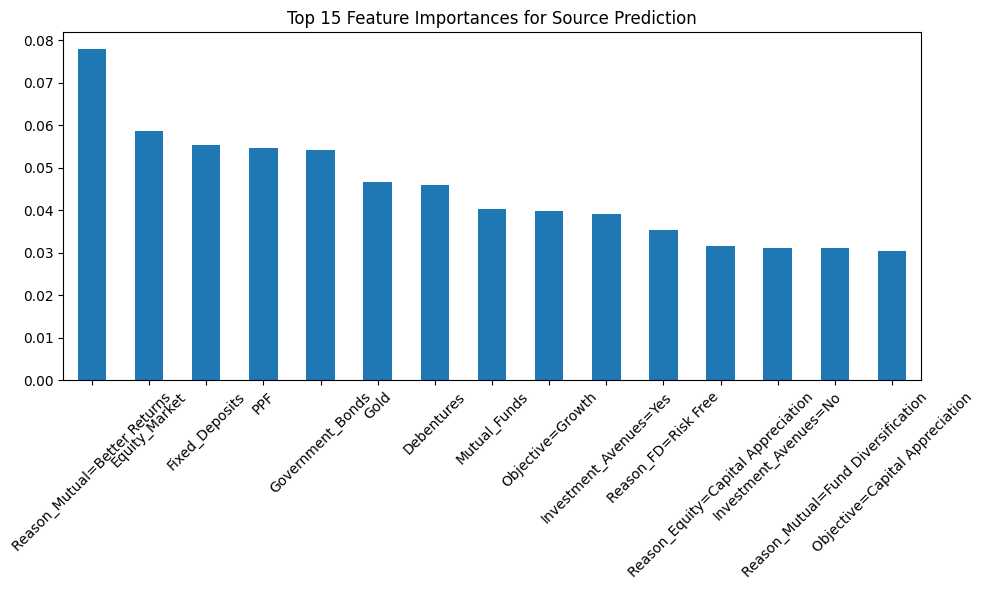

In [ ]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
importances.head(15).plot(kind='bar')
plt.title('Top 15 Feature Importances for Source Prediction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


=== DETAILED PERFORMANCE ===
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       954
           1       1.00      1.00      1.00       267
           2       1.00      1.00      1.00       801
           3       1.00      1.00      1.00       378

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00      1.00      1.00      2400



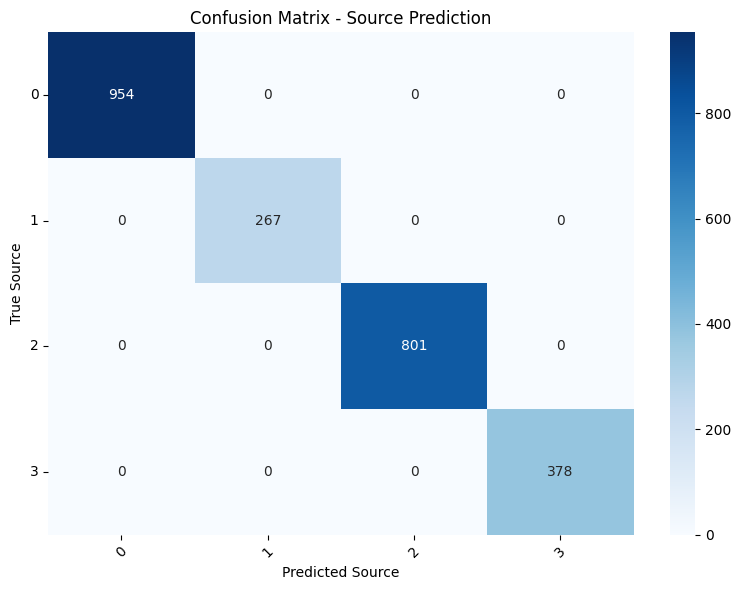

In [ ]:
# === DETAILED ANALYSIS ===
print("\n=== DETAILED PERFORMANCE ===")
best_model = rf_model
y_pred_best = best_model.predict(X_val_encoded)

print("Classification Report:")
print(classification_report(y_val, y_pred_best))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_)
plt.title('Confusion Matrix - Source Prediction')
plt.ylabel('True Source')
plt.xlabel('Predicted Source')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# === PER-CLASS ACCURACY ===
print("\n=== PER-CLASS ACCURACY ===")
class_accuracy = {}
for source in best_model.classes_:
    mask = (y_val == source)
    if mask.sum() > 0:
        accuracy_class = (y_pred_best[mask] == source).sum() / mask.sum()
        class_accuracy[source] = accuracy_class
        print(f"{source}: {accuracy_class:.3f} ({mask.sum()} samples)")


=== PER-CLASS ACCURACY ===
0: 1.000 (954 samples)
1: 1.000 (267 samples)
2: 1.000 (801 samples)
3: 1.000 (378 samples)


In [ ]:
# === BUSINESS INSIGHTS ===
print("\n=== BUSINESS INSIGHTS ===")
print("What drives people to use different information sources?")

# Analyze top features for each source
top_features = importances.head(10)
print("\nTop factors influencing information source choice:")
for feature, importance in top_features.items():
    print(f"  {feature}: {importance:.4f}")



=== BUSINESS INSIGHTS ===
What drives people to use different information sources?

Top factors influencing information source choice:
  Reason_Mutual=Better Returns: 0.0779
  Equity_Market: 0.0586
  Fixed_Deposits: 0.0553
  PPF: 0.0546
  Government_Bonds: 0.0540
  Gold: 0.0466
  Debentures: 0.0459
  Mutual_Funds: 0.0404
  Objective=Growth: 0.0399
  Investment_Avenues=Yes: 0.0391


In [ ]:
# === MODEL COMPARISON ===
print("\n=== FINAL MODEL COMPARISON ===")
models_comparison = []
for name, model in models.items():
    model.fit(X_train_encoded, y_train)
    y_pred = model.predict(X_val_encoded)
    accuracy = accuracy_score(y_val, y_pred)
    models_comparison.append({'Model': name, 'Accuracy': accuracy})

comparison_df = pd.DataFrame(models_comparison)
print(comparison_df.sort_values('Accuracy', ascending=False))




=== FINAL MODEL COMPARISON ===
                 Model  Accuracy
0        Random Forest       1.0
1  Logistic Regression       1.0
2              XGBoost       1.0
